# Get Data

### import modules

In [1]:
from nilearn import image, datasets, input_data, plotting

import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

### extracting data from certain coordinates

In [2]:
exampleSeeds = [(-48,-50,4),(-30,-40,66),(0,10,10)]

In [3]:
seedMaskerRaw = input_data.NiftiSpheresMasker(exampleSeeds,radius=5,
                                              standardize=False,detrend=False).fit()

In [4]:
seedMaskerStd = input_data.NiftiSpheresMasker(exampleSeeds,radius=5,
                                              standardize=True,detrend=True).fit()

### extracting voxel-wise data

In [5]:
brainMaskerRaw = input_data.NiftiMasker(mask_img='../masks/MNI152_T1_2mm_brain_mask.nii.gz',
                                        standardize=False,detrend=False).fit()

In [6]:
brainMaskerStd = input_data.NiftiMasker(mask_img='../masks/MNI152_T1_2mm_brain_mask.nii.gz',
                                        standardize=True,detrend=True).fit()

### use masker to get data from run

In [7]:
def getData(i,masker,conf=True):
    # get fmri run
    epi = '../data/wrrun00%s.nii.gz'%i
    #get movement parameters
    movement = '../data/rp_run00%s.txt'%i
    
    # extract data
    if conf:
        data=masker.transform(epi,confounds=movement)
    else:
        data=masker.transform(epi)
        
    # put into dataframe
    dataDf = pd.DataFrame(data)
    #get design file
    designDf = pd.read_csv('../data/run%s.csv'%i)
    designDf['TR'] = range(0,241,10)
    return dataDf,designDf

Example:

In [8]:
dataDf,designDf = getData(1,seedMaskerRaw,conf=False)

In [9]:
dataDf

,0,1,2
0,750.827160,912.814815,1026.493827
1,747.950617,908.271605,1026.407407
2,751.987654,911.123457,1026.790123
3,745.481481,908.111111,1008.679012
4,738.432099,915.641975,1024.740741
5,739.012346,910.592593,1026.913580
6,738.592593,907.074074,1015.246914
7,740.185185,907.950617,1002.024691
8,747.259259,911.580247,1030.469136
9,738.814815,912.024691,1023.913580


In [10]:
designDf

,condition,content,TR
0,rest,rest,0
1,words,animals,10
2,places,citysquare,20
3,faces,family,30
4,movements,badminton,40
5,words,tools,50
6,faces,friends,60
7,places,market,70
8,rest,rest,80
9,movements,tennis,90


### assign correct volumes to each condition

In [11]:
def reshapeDesign(designDf,start):
    
    nums = [('00%s_'%(x+start))[-4:] for x in designDf.index]
    designDf['names'] = designDf['condition']+'_'+nums+designDf['content']

    trDf = pd.DataFrame()
    for j in designDf.index:
        thisDf = pd.DataFrame( np.array([designDf.loc[j]]*10) )
        thisDf.columns = designDf.columns
        trDf = trDf.append(thisDf)
        
    # shift by two TR (account for HRF-delay of ca. 6 seconds)
    trDf.index = range(2,trDf.shape[0]+2)
    
    return trDf

In [12]:
trDf = reshapeDesign(designDf,1)

In [13]:
trDf

,condition,content,TR,names
2,rest,rest,0,rest_001_rest
3,rest,rest,0,rest_001_rest
4,rest,rest,0,rest_001_rest
5,rest,rest,0,rest_001_rest
6,rest,rest,0,rest_001_rest
7,rest,rest,0,rest_001_rest
8,rest,rest,0,rest_001_rest
9,rest,rest,0,rest_001_rest
10,rest,rest,0,rest_001_rest
11,rest,rest,0,rest_001_rest


In [14]:
def makeBlocks(trDf,dataDf):
    blockDf = pd.concat([trDf,dataDf],axis=1)
    blockDf.index = [blockDf['names'],blockDf.index]
    meanBlockDf = blockDf.groupby(level=0).mean()
    return blockDf,meanBlockDf

Example:

In [15]:
blockDf,meanBlockDf = makeBlocks(trDf,dataDf)

In [16]:
blockDf.tail(10)

condition   content   TR                   names  \
names                                                                          
movements_025_highjump 243  movements  highjump  240  movements_025_highjump   
                       244  movements  highjump  240  movements_025_highjump   
                       245  movements  highjump  240  movements_025_highjump   
                       246  movements  highjump  240  movements_025_highjump   
                       247  movements  highjump  240  movements_025_highjump   
                       248  movements  highjump  240  movements_025_highjump   
                       249  movements  highjump  240  movements_025_highjump   
                       250  movements  highjump  240  movements_025_highjump   
                       251  movements  highjump  240  movements_025_highjump   
NaN                    252        NaN       NaN  NaN                     NaN   

                                     0           1            2  
names                                                            
movements_025_highjump 243  735.617284  914.148148  1021.086420  
                       244  732.876543  915.407407  1027.296296  
                       245  738.604938  917.617284  1026.728395  
                       246  737.641975  906.703704  1013.827160  
                       247  744.172840  915.901235   997.209877  
                       248  742.703704  913.987654  1031.962963  
                       249  734.555556  911.222222  1021.086420  
                       250  738.703704  918.987654  1011.283951  
                       251  740.246914  906.283951  1011.098765  
NaN                    252  735.222222  913.876543  1011.197531

In [17]:
meanBlockDf.tail(10)

,0,1,2
names,,,
rest_001_rest,743.844444,911.790123,1019.886420
rest_009_rest,744.341975,910.122222,1019.759259
rest_014_rest,742.200000,909.923457,1019.290123
rest_019_rest,735.297531,913.002469,1017.111111
rest_023_rest,741.511111,911.318519,1019.334568
words_002_animals,753.325926,909.634568,1020.012346
words_006_tools,751.912346,903.916049,1016.113580
words_012_cities,751.165432,903.855556,1020.492593
words_018_countries,745.416049,907.337037,1020.122222


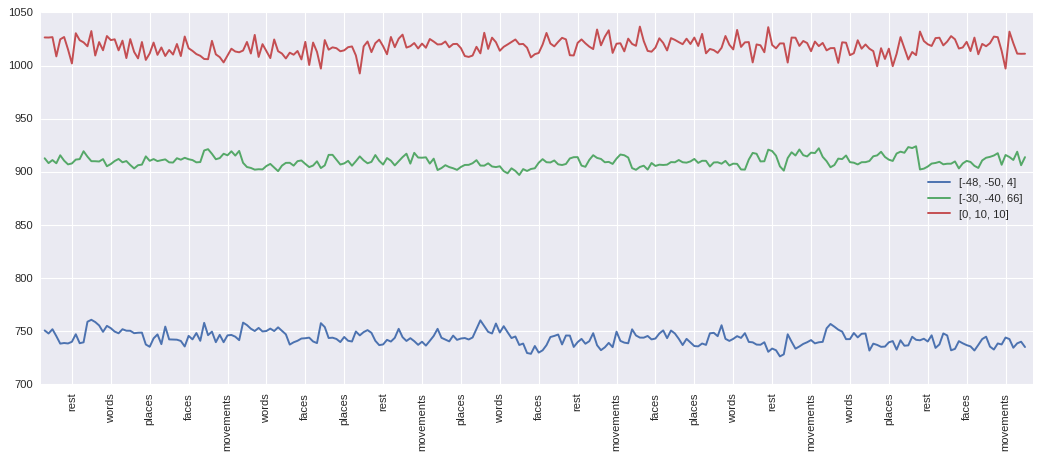

In [18]:
fig,ax = plt.subplots(1,1,figsize=(16,6))
for i,seed in enumerate(seedMaskerRaw.seeds_):
    plt.plot( blockDf[i].values,label=seed)
plt.xlim(-1,blockDf.shape[0]+1)

xConds = blockDf['condition'].dropna()
plt.xticks(np.arange(2,xConds.shape[0]+2)[5::10],xConds[5::10],rotation=90)
sns.despine()

plt.legend(loc='best')

plt.show()

### with standardization

In [19]:
dataDf,designDf = getData(1,seedMaskerStd,conf=False)
trDf = reshapeDesign(designDf,1)
blockDf,meanBlockDf = makeBlocks(trDf,dataDf)

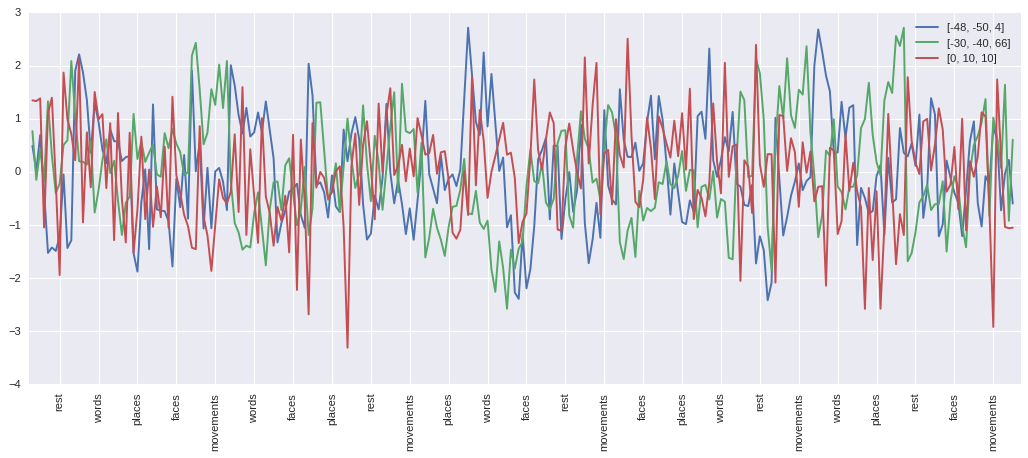

In [20]:
fig,ax = plt.subplots(1,1,figsize=(16,6))
for i,seed in enumerate(seedMaskerStd.seeds_):
    plt.plot( blockDf[i].values,label=seed)
plt.xlim(-1,blockDf.shape[0]+1)

xConds = blockDf['condition'].dropna()
plt.xticks(np.arange(2,xConds.shape[0]+2)[5::10],xConds[5::10],rotation=90)
sns.despine()

plt.legend(loc='best')

plt.show()

In [21]:
def reshapeThis(df):
    
    trDf = pd.DataFrame()
    for j in df.index:
        thisDf = pd.DataFrame( np.array([df.loc[j]]*10) )
        thisDf.columns = df.columns
        trDf = trDf.append(thisDf)
        
    # shift by two TR (account for HRF-delay of ca. 6 seconds)
    trDf.index = range(2,trDf.shape[0]+2)
    
    return trDf

In [22]:
meanTrBlockDf=blockDf.groupby('TR').mean()
meanTrDf = reshapeThis(meanTrBlockDf)

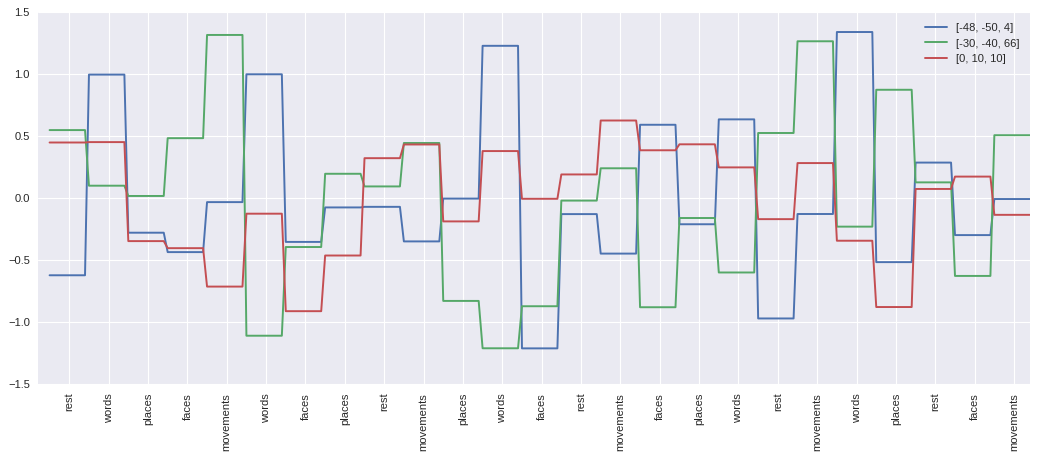

In [23]:
fig,ax = plt.subplots(1,1,figsize=(16,6))
for i,seed in enumerate(seedMaskerStd.seeds_):
    plt.plot( meanTrDf.index,meanTrDf[i].values,label=seed)
plt.xlim(-1,meanTrDf.shape[0]+1)
plt.legend(loc='best')

xConds = blockDf['condition'].dropna()
plt.xticks(np.arange(2,xConds.shape[0]+2)[5::10],xConds[5::10],rotation=90)
sns.despine()

plt.legend(loc='best')

plt.show()

### save all whole-brain data block-wise

In [24]:
bigBlockDf = pd.DataFrame()
for i,j in zip([1,2,3],[1,26,51]):
      
    dataDf,designDf = getData(i,brainMaskerStd,conf=True)
    trDf = reshapeDesign(designDf,j)
    blockDf,meanBlockDf = makeBlocks(trDf,dataDf)
  
    meanBlockDf.index = [['run00%s'%i]*meanBlockDf.shape[0],meanBlockDf.index]
    bigBlockDf = pd.concat([bigBlockDf,meanBlockDf])

In [25]:
bigBlockDf

0         1         2         3       \
       names                                                             
run001 faces_004_family        -0.337221 -0.261674 -0.447705 -0.463183   
       faces_007_friends        0.406736  0.427125  0.015802  0.134407   
       faces_013_movieactors   -0.803729 -0.765207  0.315829 -0.335106   
       faces_016_athletes       0.416349  0.372681  0.368322  0.256957   
       faces_024_tvactors       0.130858 -0.027075 -0.214070  0.041683   
       movements_005_badminton  0.232851  0.211707  0.175249 -0.179907   
       movements_010_tennis     0.323449  0.174717 -0.318922  0.865977   
       movements_015_swimming  -0.410231 -0.373177 -0.214435 -0.214162   
       movements_020_soccer    -0.365402 -0.422123 -0.290296 -0.161451   
       movements_025_highjump   0.032260  0.165307 -0.162336 -0.339263   
       places_003_citysquare   -0.409870 -0.343361  0.178760 -0.154857   
       places_008_market       -0.525955 -0.532538  0.320622 -0.216594   
       places_011_tramstation   0.027584  0.157118 -0.403917 -0.314847   
       places_017_trainstation -0.056431 -0.060108  0.103397 -0.234649   
       places_022_school        0.081708  0.126733  0.112864 -0.253421   
       rest_001_rest            0.383816  0.345413 -0.421839  0.204600   
       rest_009_rest            0.210772  0.154903  0.267624  0.232909   
       rest_014_rest           -0.099611 -0.071073  0.516288  0.742223   
       rest_019_rest           -0.369821 -0.354001  0.156842  0.201624   
       rest_023_rest            0.800571  0.898288  0.118228  0.316837   
       words_002_animals        0.377199  0.371269  0.208753  0.294844   
       words_006_tools          0.079687  0.169097 -0.180427 -0.336351   
       words_012_cities        -0.241019 -0.297598  0.307364  0.160643   
       words_018_countries     -0.154996 -0.147946 -0.474708 -0.483925   
       words_021_occupations    0.085977 -0.023571  0.044882  0.334655   
run002 faces_029_politicians    0.344705  0.118515 -0.089767  0.536890   
       faces_033_lectureres     0.278460  0.138843 -0.074483 -0.319463   
       faces_036_teachers      -0.436396 -0.250727  0.840851 -0.930371   
       faces_042_family         0.008166  0.106999  0.300277  0.359707   
       faces_047_friends       -0.133380 -0.201361  0.026851 -0.025188   
...                                  ...       ...       ...       ...   
       words_028_fruits        -0.344076 -0.413111 -0.984599 -0.113261   
       words_034_clothing      -0.406813 -0.589992 -0.170627  0.043201   
       words_039_vegetables    -0.142082  0.120061  0.073976 -0.146874   
       words_044_furniture     -0.035064  0.176548 -0.059665 -0.041317   
       words_048_colors         0.079452 -0.229015 -0.568590 -0.143852   
run003 faces_051_movieactors    0.035837  0.277597  0.414609  0.219754   
       faces_058_athletes       0.203997  0.147367 -0.260475 -0.230707   
       faces_064_family        -0.239555 -0.282957  0.317728  0.033827   
       faces_067_friends       -0.129945 -0.308557 -0.050691  0.233076   
       faces_074_politicians   -0.186277 -0.274415 -0.137317  0.144366   
       movements_055_badminton -0.074365 -0.452001 -0.113353  0.067093   
       movements_060_swimming   0.112817  0.274512  0.353906 -0.199740   
       movements_065_badminton  0.118147  0.130686 -0.134266  0.515010   
       movements_070_tennis     0.626708  0.519312 -0.423559 -0.076280   
       movements_075_climbing   0.381093  0.461640  0.332153 -0.286576   
       places_054_market       -0.384518 -0.010347 -0.656230 -0.432311   
       places_059_school        0.334278  0.330364 -0.496889 -0.122829   
       places_063_citysquare    0.624635  0.372718  0.054091  0.447432   
       places_068_market        0.315290  0.428699  0.336721 -0.732507   
       places_071_church       -0.573308 -0.224676 -0.199774 -0.470168   
       rest_053_rest            0.015891  0.052901  0.777762 -0.200258   
       rest_057_rest            0.1215

In [26]:
def makeFiles(bigBlockDf,masker):
    # for the training run (all except run003)
    for i in bigBlockDf.drop('run003').index:
        thisIm = masker.inverse_transform(bigBlockDf.loc[i])
        thisName = '../train/%s.nii.gz'%i[-1]
        print 'writing %s to file...'%thisName
        thisIm.to_filename(thisName)
    # for the test run (dropping 1&2, leaving 3)
    for i in bigBlockDf.drop(['run001','run002']).index:
        thisIm = masker.inverse_transform(bigBlockDf.loc[i])
        thisName = '../test/%s.nii.gz'%i[-1]
        print 'writing %s to file...'%thisName
        thisIm.to_filename(thisName)
    return

In [27]:
makeFiles(bigBlockDf,brainMaskerStd)

writing ../train/faces_004_family.nii.gz to file...
writing ../train/faces_007_friends.nii.gz to file...
writing ../train/faces_013_movieactors.nii.gz to file...
writing ../train/faces_016_athletes.nii.gz to file...
writing ../train/faces_024_tvactors.nii.gz to file...
writing ../train/movements_005_badminton.nii.gz to file...
writing ../train/movements_010_tennis.nii.gz to file...
writing ../train/movements_015_swimming.nii.gz to file...
writing ../train/movements_020_soccer.nii.gz to file...
writing ../train/movements_025_highjump.nii.gz to file...
writing ../train/places_003_citysquare.nii.gz to file...
writing ../train/places_008_market.nii.gz to file...
writing ../train/places_011_tramstation.nii.gz to file...
writing ../train/places_017_trainstation.nii.gz to file...
writing ../train/places_022_school.nii.gz to file...
writing ../train/rest_001_rest.nii.gz to file...
writing ../train/rest_009_rest.nii.gz to file...
writing ../train/rest_014_rest.nii.gz to file...
writing ../train

### get secret run

In [28]:
def getSecretData(i,masker,conf=True):
    # get fmri run
    epi = '../data/wrrun00%s.nii.gz'%i
    #get movement parameters
    movement = '../data/rp_run00%s.txt'%i
    
    # extract data
    if conf:
        data=masker.transform(epi,confounds=movement)
    else:
        data=masker.transform(epi)
        
    # put into dataframe
    dataDf = pd.DataFrame(data)
    #get design file
    designDf = pd.read_csv('../data/run%s.csv'%i)
    print data.shape[0]
    print range(0,data.shape[0]-10,10)
    designDf['TR'] = range(0,data.shape[0]-10,10)
    return dataDf,designDf

In [29]:
dataDf,designDf = getSecretData(0,brainMaskerStd,conf=True)
trDf = reshapeDesign(designDf,0)
blockDf,meanBlockDf = makeBlocks(trDf,dataDf)

23
[0, 10]


In [30]:
for i in meanBlockDf.index:
    thisIm = brainMaskerStd.inverse_transform(meanBlockDf.loc[i])
    thisName = '../outofsample/%s.nii.gz'%i
    print 'writing %s to file...'%thisName
    thisIm.to_filename(thisName)

writing ../outofsample/rest_000_rest.nii.gz to file...
writing ../outofsample/secret_001_secret.nii.gz to file...


### store smoothed data

In [31]:
smooMasker = input_data.NiftiMasker(mask_img='../masks/MNI152_T1_2mm_brain_mask.nii.gz',
                                    smoothing_fwhm=8).fit()

In [32]:
trainList = ['../train/%s'%x for x in os.listdir('../train/') ]
testList = ['../test/%s'%x for x in os.listdir('../test/') ]
secretList = ['../outofsample/%s'%x for x in os.listdir('../outofsample/') ]

bigList = trainList+testList+secretList

In [33]:
bigList

['../train/places_003_citysquare.nii.gz',
 '../train/faces_004_family.nii.gz',
 '../train/faces_007_friends.nii.gz',
 '../train/faces_013_movieactors.nii.gz',
 '../train/faces_016_athletes.nii.gz',
 '../train/faces_024_tvactors.nii.gz',
 '../train/faces_029_politicians.nii.gz',
 '../train/faces_033_lectureres.nii.gz',
 '../train/faces_036_teachers.nii.gz',
 '../train/faces_042_family.nii.gz',
 '../train/faces_047_friends.nii.gz',
 '../train/movements_005_badminton.nii.gz',
 '../train/movements_010_tennis.nii.gz',
 '../train/movements_015_swimming.nii.gz',
 '../train/movements_020_soccer.nii.gz',
 '../train/movements_025_highjump.nii.gz',
 '../train/movements_030_climbing.nii.gz',
 '../train/movements_035_huerdlerace.nii.gz',
 '../train/movements_040_archery.nii.gz',
 '../train/movements_045_ropeskipping.nii.gz',
 '../train/movements_050_juggling.nii.gz',
 '../train/places_008_market.nii.gz',
 '../train/places_011_tramstation.nii.gz',
 '../train/places_017_trainstation.nii.gz',
 '../tra

In [34]:
for im in bigList:
    smooIm = smooMasker.inverse_transform(smooMasker.transform(im))
    imName = im.split('/')[-1]
    print imName
    smooIm.to_filename('../smooIms/s8%s'%imName)

places_003_citysquare.nii.gz
faces_004_family.nii.gz
faces_007_friends.nii.gz
faces_013_movieactors.nii.gz
faces_016_athletes.nii.gz
faces_024_tvactors.nii.gz
faces_029_politicians.nii.gz
faces_033_lectureres.nii.gz
faces_036_teachers.nii.gz
faces_042_family.nii.gz
faces_047_friends.nii.gz
movements_005_badminton.nii.gz
movements_010_tennis.nii.gz
movements_015_swimming.nii.gz
movements_020_soccer.nii.gz
movements_025_highjump.nii.gz
movements_030_climbing.nii.gz
movements_035_huerdlerace.nii.gz
movements_040_archery.nii.gz
movements_045_ropeskipping.nii.gz
movements_050_juggling.nii.gz
places_008_market.nii.gz
places_011_tramstation.nii.gz
places_017_trainstation.nii.gz
places_022_school.nii.gz
places_026_church.nii.gz
places_032_basement.nii.gz
places_038_promenade.nii.gz
places_041_cityofkiel.nii.gz
places_049_univesity.nii.gz
rest_001_rest.nii.gz
rest_009_rest.nii.gz
rest_014_rest.nii.gz
rest_019_rest.nii.gz
rest_023_rest.nii.gz
rest_027_rest.nii.gz
rest_031_rest.nii.gz
rest_037_re

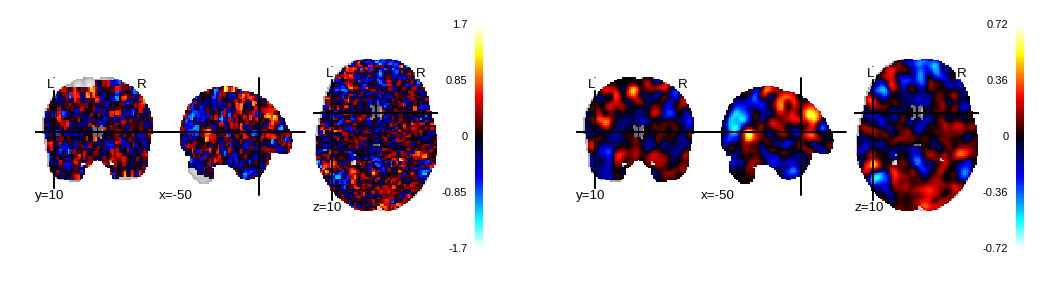

In [35]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,4))
p1 = plotting.plot_stat_map('../train/words_028_fruits.nii.gz',axes=ax1,cut_coords=(-50,10,10))
p2 = plotting.plot_stat_map('../smooIms/s8words_028_fruits.nii.gz',axes=ax2,cut_coords=(-50,10,10))
plt.show()